# SIS hyperparameters
Generate an epidemic with some unknown "true" $(\lambda, \kappa)$, then try to infer them by doing a grid search and comparing the log-likelihood (negative Bethe free energy)

In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/MatrixProductBP`


In [2]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, Plots, Printf, IndexedGraphs, Statistics, Random
using Base.Threads
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [33]:
include("../../telegram/notifications.jl")

default_tg_text (generic function with 1 method)

In [48]:
T = 15
N = 1000
k = 4
gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
t = SimpleGraph(prim_mst(gg))
g = IndexedGraph(t)
@assert is_connected(g)
λ_true = 0.2
ρ_true = 0.1
γ = 3/N;

In [49]:
sis_true = SIS(g, λ_true, ρ_true, T; γ)
X, _ = onesample(mpbp(sis_true));

In [50]:
lambdas = 0.1:0.01:0.3
kappas = 0.01:0.01:0.2
f = fill!(lambdas*kappas', 0);

In [51]:
nobs = (T*N) ÷ 1

15000

In [ ]:
@telegram "hyperparams" begin
    
for (i,λ) in enumerate(lambdas)
    println("## λ $i of ", length(lambdas))
    @threads for j in eachindex(kappas)
        ρ = kappas[j]
        bp = mpbp(SIS(g, λ, ρ, T; γ))
        rng = MersenneTwister(0)
        draw_node_observations!(bp.ϕ, X, nobs; rng)
        iterate!(bp; maxiter=100, tol=1e-3, showprogress=false, svd_trunc=TruncBond(9))
        f[i,j] = bethe_free_energy(bp)
    end
end
    
end

Inference of hyperparameters for 1 realization of an epidemic with N=1000, T=15, 
    15000 random observations


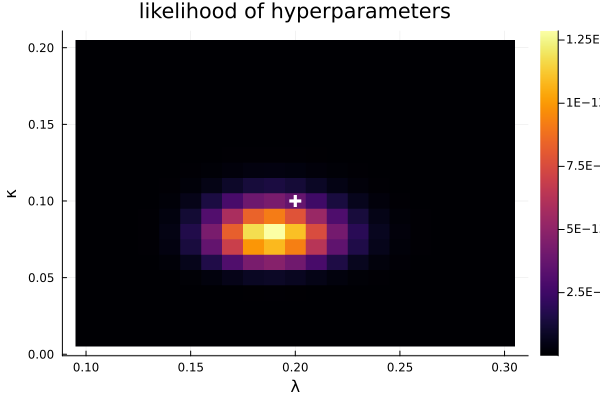

In [56]:
println("Inference of hyperparameters for 1 realization of an epidemic with N=$N, T=$T, 
    $nobs random observations")
heatmap(lambdas, kappas, exp.(-f)',title="likelihood of hyperparameters", xlabel="λ", ylabel="ρ")
scatter!([λ_true], [ρ_true], m=:plus, label="", c=:white, msw=4, ms=6)